In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx

In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()


In [3]:
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [19]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [40]:
users['age'] = 2018 - users['birth_date'].dt.year

In [6]:
animes.head()

,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,...,premiered,broadcast,related,producer,licensor,studios,genres,opening_theme,ending_theme,duration_min
anime_id,,,,,,,,,,,,,,,,,,,,,
11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0
2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,...,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0
5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,...,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0
721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0
12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,...,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0


In [7]:
animelists.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [8]:
users.head()

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
username,,,,,,,,,,,,,,,,
karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391
Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,2017-07-10 06:52:54,6.15,6.0,4903
bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,9701
terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24,NaN,2010-05-10,2012-10-18 19:06:00,9.70,6.0,697
Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24,NaN,2015-11-26,2018-05-10 20:53:37,7.86,0.0,1847


### comparison of all and active users
Active users are users with some ratings in last 3 months

In [42]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [43]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

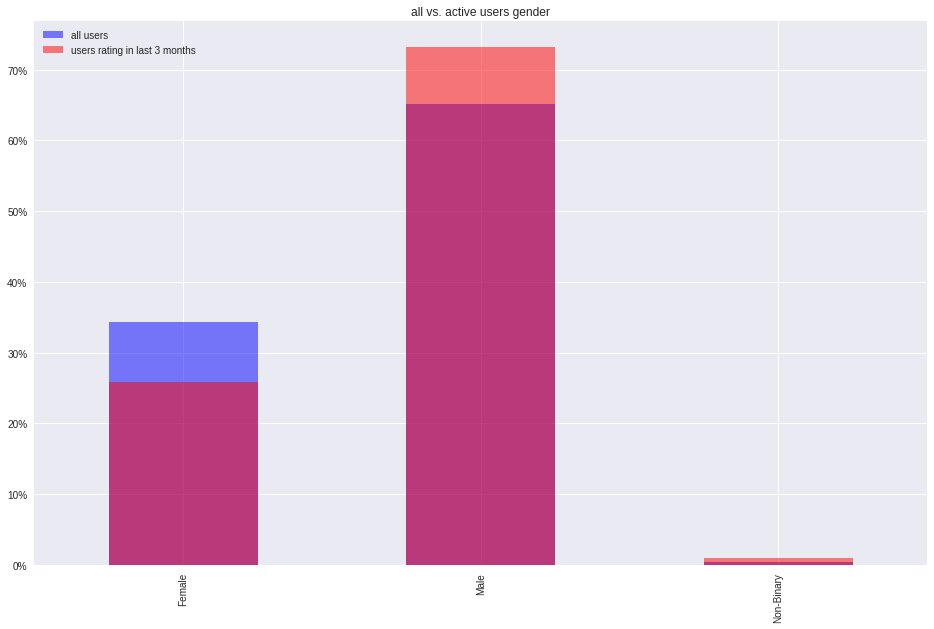

In [44]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

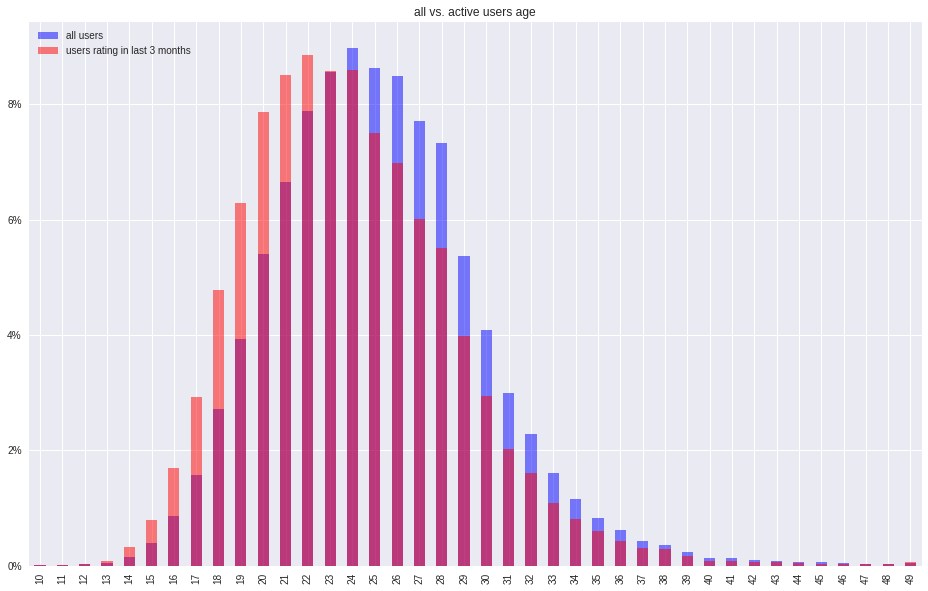

In [45]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)